<a href="https://colab.research.google.com/github/suriyanrk/Topic-Modeling-on-BBC-News-Articles/blob/main/Topic_Modeling_on_BBC_News_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

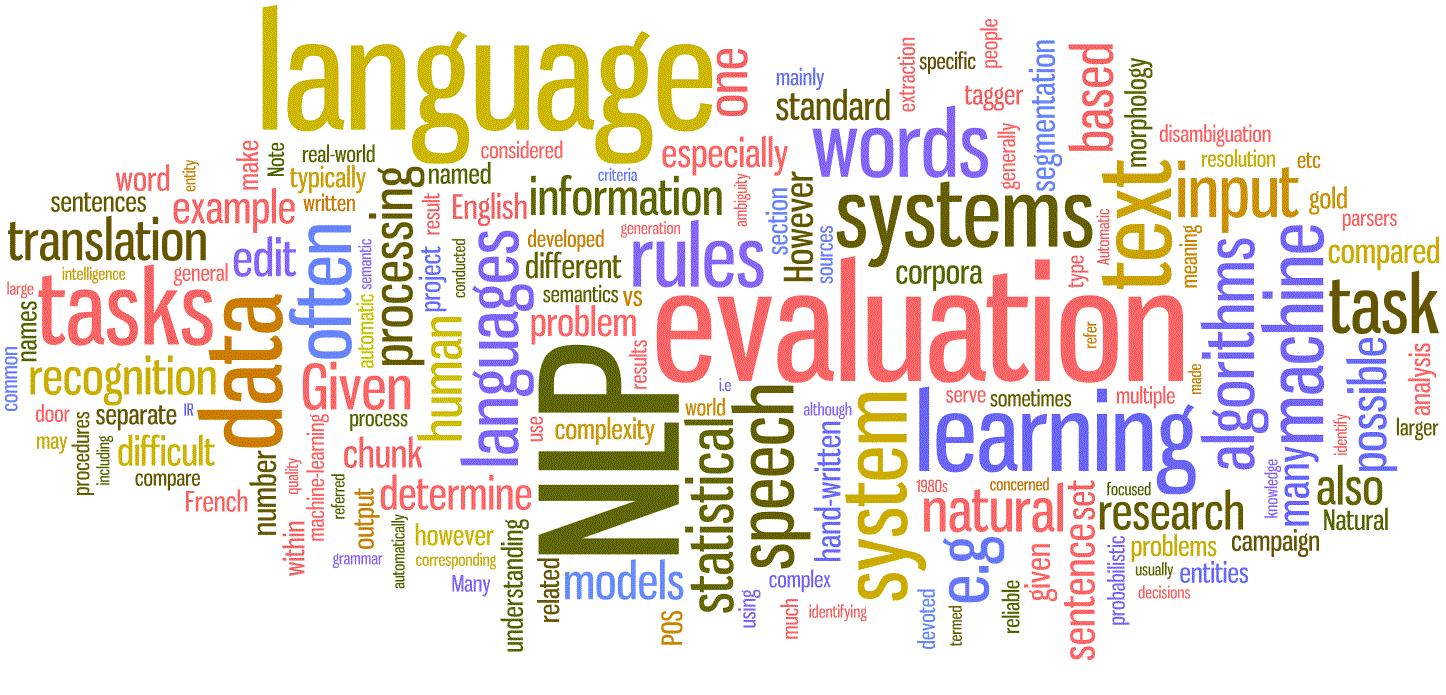


## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

**The problem that we would like to talk about here is to find the best segregation of documents according to their topics. This kind of separation can be used for assigning a topic to a document (which is called topic labeling) or for general determination of compressed characteristics of a huge text data set.**

# **Mounting Drive**

In [124]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing The Modules**

In [125]:
import pandas as pd
import numpy as np
import string
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.corpora as corpora
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nltk.download('stopwords')
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [126]:
pip install autocorrect

In [127]:
!pip install pyLDAvis

**First we have to develop our own dataset for our dataset, we will read all the downloaded articles into one list corpus. We will use the folder name as a list of labels.Then we can covert them into dataframe**

In [198]:
News=[]
Type=[]

path="/content/drive/MyDrive/Capestone/bbc"
folders=["business","entertainment","politics","sport","tech"] 
for i in folders:
    files=os.listdir(path+'/'+i)
    for text_file in files:
        file_path=path + '/'+i+'/'+text_file
        with open(file_path,'rb') as f:
            data=f.read()
        News.append(data)
        Type.append(i)
      

data={'news':News,'type':Type}
df = pd.DataFrame(data) 

**Basic Operation**

In [199]:
df.head()

,news,type
0,b'Yukos unit buyer faces loan claim\n\nThe own...,business
1,b'Ad sales boost Time Warner profit\n\nQuarter...,business
2,b'Dollar gains on Greenspan speech\n\nThe doll...,business
3,b'US trade gap hits record in 2004\n\nThe gap ...,business
4,b'High fuel prices hit BA\'s profits\n\nBritis...,business


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    2225 non-null   object
 1   type    2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [201]:
#Removing Duplicate rows
df=df.drop_duplicates()

In [202]:
#Relative frequncies of unique values
df.type.value_counts(normalize=True)*100

sport            23.742360
business         23.648331
politics         18.946874
entertainment    17.348378
tech             16.314057
Name: type, dtype: float64

# **Text Preprocessing**

In [203]:
# Converting column into astring
df['news'] = df['news'].astype('str') 

In [204]:
# Removing HTML Tag
import re
def remove_html_tags(text):
	html_pattern = r'<.*?>'
	without_html = re.sub(pattern=html_pattern, repl=' ', string=text)
	return without_html

In [205]:
df['news']=df['news'].apply(remove_html_tags)

In [206]:
# Removing URLs
def remove_urls(text):
	url_pattern = r'https?://\S+|www\.\S+' 
	without_urls = re.sub(pattern=url_pattern, repl=' ', string=text)
	return without_urls

In [207]:
df['news']=df['news'].apply(remove_urls)

In [208]:
# Removing numbers
def remove_numbers(text):
	number_pattern = r'\d+'
	without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
	return without_number

In [209]:
df['news']=df['news'].apply(remove_numbers)

In [210]:
# Removing single Charecter
def remove_single_char(text):
	single_char_pattern = r'\s+[a-zA-Z]\s+'
	without_sc = re.sub(pattern=single_char_pattern, repl="", string=text)
	return without_sc

In [211]:
df['news']=df['news'].apply(remove_single_char)

In [212]:
stop_list=list(stopwords.words('english'))
stop_list.append('would')
stop_list.append('could')
stop_list.append('say')

In [213]:
# Removing StopWord
def Change_text(msg):
  punc=[char if str(char) not in string.punctuation else " " for char in msg ]
  no_punc=''.join(punc)
  main_text=[word for word in no_punc.split() if word.lower() not in stop_list]
  return ' '.join(main_text)

In [214]:
# Doing Lemmatization
def lemmatization(texts):
  sentence=''
  allowed_postags=['NOUN','ADJ','VERB','ADV']
  texts_out=[]
  doc=nlp(texts)
  texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return ' '.join(texts_out[0])

In [227]:
df['news']=df['news'].apply(Change_text)

In [216]:
nlp=spacy.load('en',disable=['parser', 'ner'])
df['news']=df['news'].apply(lemmatization)

# **The EDA**

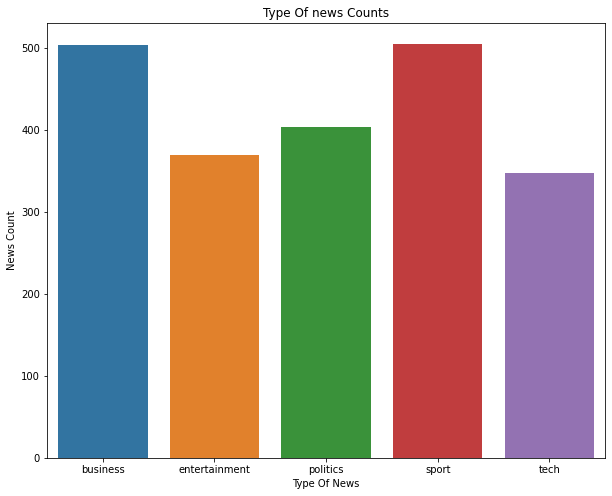

In [217]:
import warnings 
plt.figure(figsize=(10,8))
warnings.filterwarnings("ignore")
sns.countplot(df['type'], data=df)
plt.xlabel("Type Of News")
plt.ylabel("News Count")
plt.title("Type Of news Counts")
plt.show()

In [228]:
df['length']=df['news'].apply(len)
df.head()

,news,type,length,word_count
0,unit buyer face loan claim owner embattle russ...,business,738,115
1,ad sale boost profit profit medium giant jump ...,business,1320,191
2,gain speech dollar hit high level almost month...,business,1200,173
3,trade gap hit record gap export import hit tim...,business,1056,161
4,high fuel price hit profit blame high fuel pri...,business,1222,182


In [229]:
df['word_count'] = df['news'].apply(lambda x: len(str(x).split(" ")))
df.head()

,news,type,length,word_count
0,unit buyer face loan claim owner embattle russ...,business,738,110
1,ad sale boost profit profit medium giant jump ...,business,1320,185
2,gain speech dollar hit high level almost month...,business,1200,171
3,trade gap hit record gap export import hit tim...,business,1056,157
4,high fuel price hit profit blame high fuel pri...,business,1222,176


In [220]:
bbc1_business = df[df['type'] == 'business']
bbc1_entertainment = df[df['type'] == 'entertainment']
bbc1_politics = df[df['type'] == 'politics']
bbc1_sport = df[df['type'] == 'sport']
bbc1_tech = df[df['type'] == 'tech']

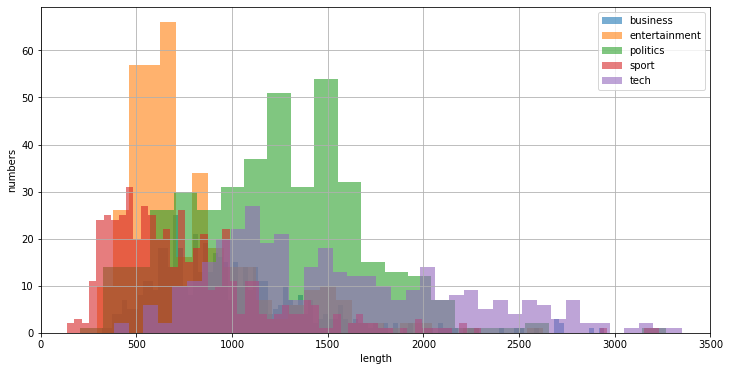

In [221]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(bbc1_business['length'], alpha = 0.6, bins=bins, label='business')
plt.hist(bbc1_entertainment['length'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(bbc1_politics['length'], alpha = 0.6, bins=bins, label='politics')
plt.hist(bbc1_sport['length'], alpha = 0.6, bins=bins, label='sport')
plt.hist(bbc1_tech['length'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,3500)
plt.grid()
plt.show()

Length of all type of topics are dense between 1500-2000 so couldn't distinguish between topic with help of word length. 

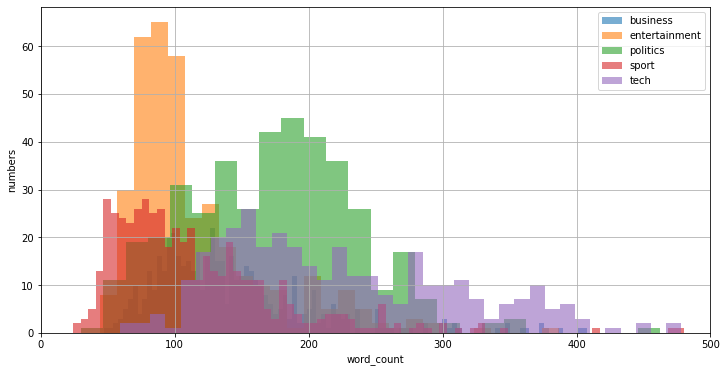

In [222]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(bbc1_business['word_count'], alpha = 0.6, bins=bins, label='business')
plt.hist(bbc1_entertainment['word_count'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(bbc1_politics['word_count'], alpha = 0.6, bins=bins, label='politics')
plt.hist(bbc1_sport['word_count'], alpha = 0.6, bins=bins, label='sport')
plt.hist(bbc1_tech['word_count'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('word_count')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,500)
plt.grid()
plt.show()

It's similar to length which is prittey obvious.

## First we develop a list of the top words used across all headlines, giving us a glimpse into the core vocabulary of the source data. Stop words are omitted here to avoid any trivial conjunctions, prepositions, etc.

In [223]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

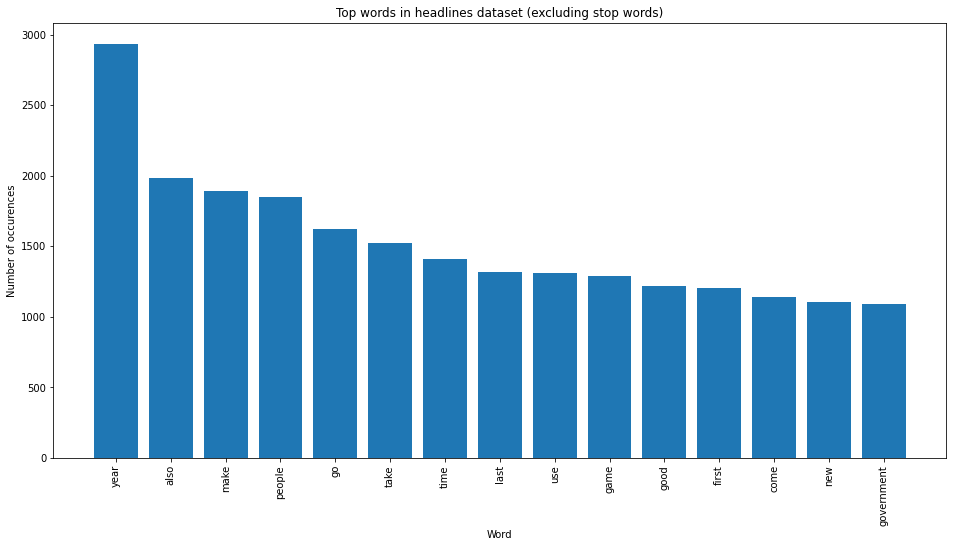

In [230]:
count_vectorizer = CountVectorizer(max_df=0.8)
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['news'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

**We could see that our top word are in our dataset are year,make**

###****WordCloud For Topic Business****

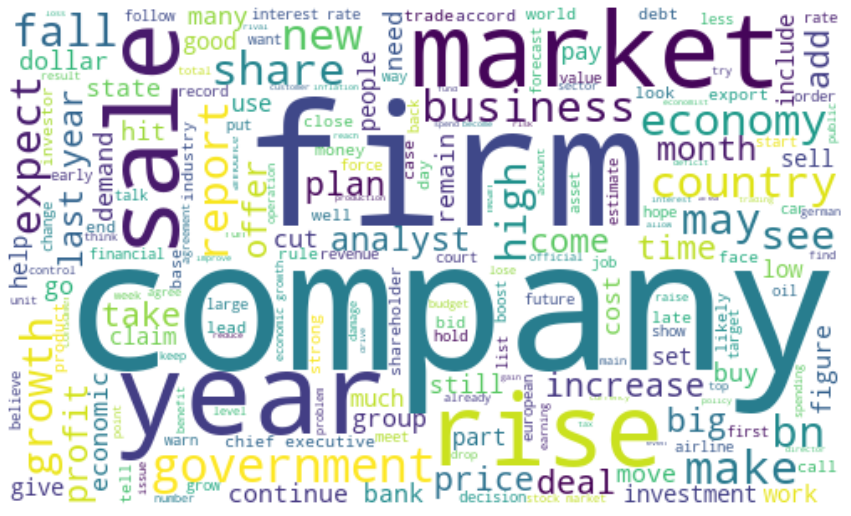

In [231]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='business']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

###****WordCloud For Topic Tech****

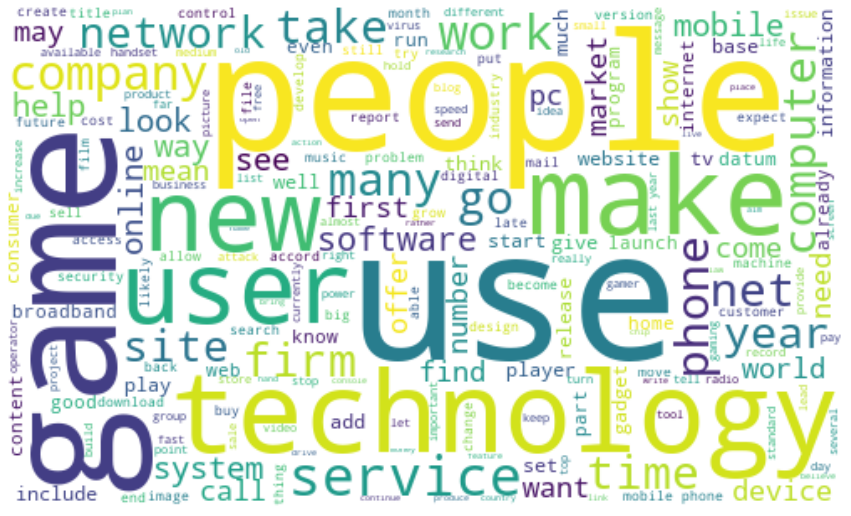

In [232]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='tech']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

###****WordCloud For Topic Sport****

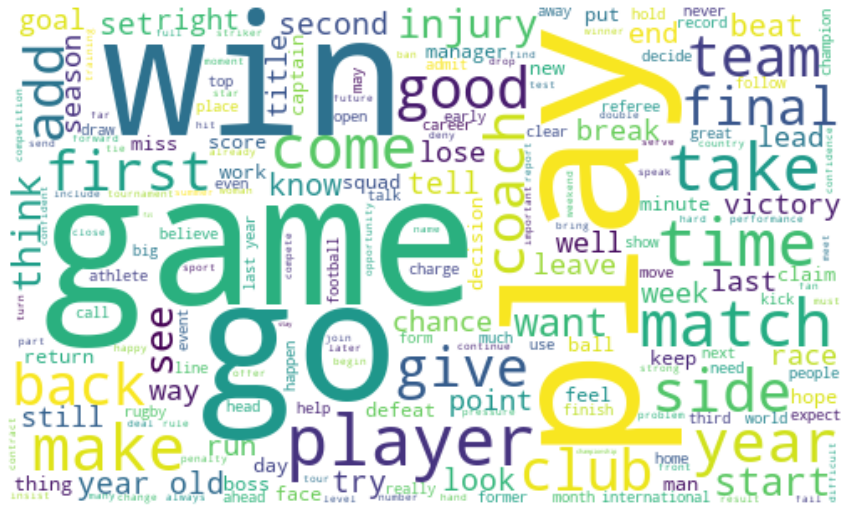

In [233]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='sport']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show() 

###****WordCloud For Topic Politics****

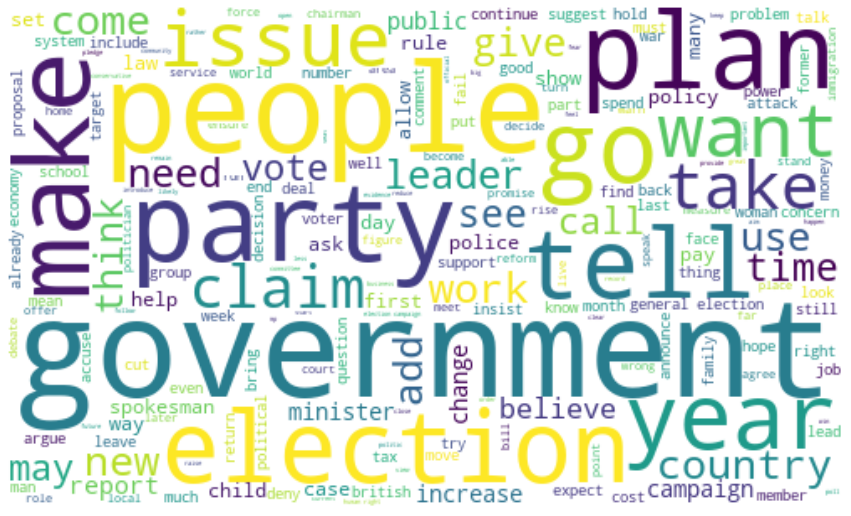

In [234]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='politics']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# **Topic Modelling**

**We now apply a clustering algorithm to the headlines corpus in order to study the topic focus of BBC News.**

**TF-IDF Vectorizer with unigram**

In [235]:
vectorizer = TfidfVectorizer(max_features=8000,min_df=0.05)
matrix=vectorizer.fit_transform(df['news'])

In [236]:
df1 = pd.DataFrame(matrix.toarray() , columns=vectorizer.get_feature_names())

In [237]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [238]:
df1.head()

,able,accept,access,accord,account,accuse,act,action,add,admit,affect,age,ago,agree,ahead,aim,allow,almost,already,also,always,amount,analyst,announce,annual,anti,appeal,appear,area,argue,ask,attack,attempt,available,average,award,away,back,bad,base,battle,beat,become,begin,believe,benefit,best,bid,big,bn,body,book,boost,boss,break,bring,british,build,business,buy,call,campaign,career,carry,case,cause,chairman,challenge,champion,chance,change,charge,chief,child,choice,choose,claim,clear,close,club,coach,come,comment,company,compare,competition,computer,concern,confirm,consider,consumer,continue,control,cost,country,course,court,create,current,currently,customer,cut,damage,date,datum,day,deal,decide,decision,demand,deny,design,develop,development,different,difficult,digital,director,double,draw,drive,drop,due,early,easy,economic,economy,effort,election,end,enough,ensure,estimate,european,even,event,ever,evidence,example,executive,exist,expect,experience,face,fact,fail,fall,family,fan,far,fast,fear,feature,feel,fight,figure,file,film,final,financial,find,firm,first,focus,follow,force,foreign,form,former,forward,fourth,free,full,fund,future,gain,game,general,get,giant,give,global,go,goal,good,government,great,group,grow,growth,half,hand,happen,hard,head,hear,help,high,hit,hold,home,hope,hour,however,idea,important,improve,include,increase,individual,industry,information,injury,insist,instead,interest,international,internet,investment,involve,issue,job,join,keep,key,know,large,last,late,later,launch,law,lead,leader,least,leave,legal,less,let,level,life,likely,line,link,list,little,live,local,long,look,lose,low,main,major,make,maker,man,manage,manager,many,market,match,may,mean,meanwhile,measure,medium,meet,meeting,member,minister,minute,miss,mobile,moment,money,month,move,movie,much,music,must,name,nation,national,need,net,network,never,new,news,next,number,offer,office,official,often,old,online,open,opportunity,order,part,particularly,party,pass,pay,people,performance,period,personal,phone,pick,place,plan,play,player,point,policy,political,popular,position,possible,power,predict,present,president,pressure,previous,price,problem,process,produce,product,production,profit,programme,project,promise,proposal,prove,provide,public,push,put,quarter,question,race,raise,range,rate,rather,reach,real,really,reason,receive,recent,recently,record,reduce,release,remain,replace,report,research,result,return,reveal,right,rise,risk,rival,role,rule,run,sale,score,season,second,security,see,seek,seem,sell,send,senior,service,set,several,share,short,show,side,sign,simply,single,small,software,soon,speak,spend,spokesman,stage,stand,star,start,state,stay,step,still,stop,story,strong,success,suggest,summer,support,sure,system,take,talk,target,tax,team,technology,tell,term,test,thing,think,third,time,title,together,top,total,trade,trial,try,turn,tv,understand,use,user,value,version,victory,video,view,vote,want,war,warn,watch,way,website,week,well,win,winner,woman,work,world,write,wrong,year,yet,young
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.103016,0.0,0.0,0.000000,0.0,0.0,0.0,0.107084,0.0,0.000000,0.000000,0.091842,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.205246,0.000000,0.119245,0.0,0.000000,0.0,0.0,0.000000,0.0,0.094679,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.230353,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.212691,0.000000,0.0,0.0,0.0,0.106345,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.361861,0.0,0.000000,0.0,0.0,0.0,0.117351,0.161752,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.120123,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.107687,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.097674,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.000000,0.130207,0.000000,0.0,0.094172,0.000000,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.1177

# **Latent Dirichilet Allocation**

In [239]:
model=LatentDirichletAllocation(n_components=5)
lda_topic_matrix=model.fit_transform(matrix)

In [240]:
doc_topic_dist = pd.DataFrame(model.transform(matrix))
doc_topic_dist.to_csv('doc_topic_dist.csv', index=False)

In [241]:
doc=pd.read_csv("doc_topic_dist.csv")
doc.columns=['topic1','topic2','topic3','topic4','topic5']

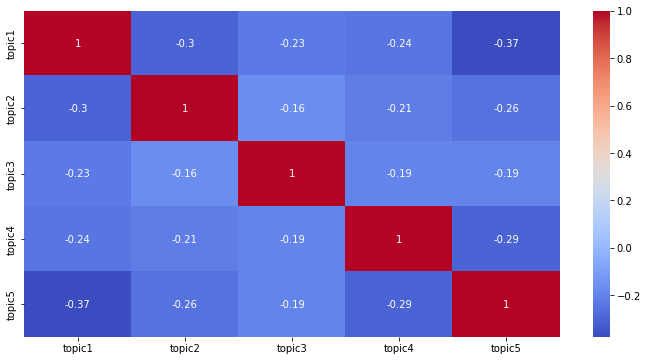

In [242]:
sns.heatmap(data=doc.corr(),annot=True,cmap='coolwarm')

In [243]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [244]:
lda_panel = pyLDAvis.sklearn.prepare(model,matrix,vectorizer,mds='tsne')
lda_panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      150.222153  -72.269554       1        1  28.663663
4       51.163364 -159.968018       2        1  22.168490
3      -73.144554   21.523815       3        1  19.030236
1      -66.410133 -110.606438       4        1  18.093128
2       54.417324   12.443444       5        1  12.044483, topic_info=            Term       Freq       Total Category  logprob  loglift
157         film  78.000000   78.000000  Default  30.0000  30.0000
35         award  45.000000   45.000000  Default  29.0000  29.0000
405         star  45.000000   45.000000  Default  28.0000  28.0000
176         game  77.000000   77.000000  Default  27.0000  27.0000
128     election  49.000000   49.000000  Default  26.0000  26.0000
280        music  41.000000   41.000000  Default  25.0000  25.0000
161         firm  59.000000   59.000000  Default  24.0000  24.0000
311        phone  31.000000   31.000000  Default  23.0000  23.0000
184         good  66.000000   66.000000  Default  22.0000  22.0000
261        match  37.000000   37.000000  Default  21.0000  21.0000
425   technology  33.000000   33.000000  Default  20.0000  20.0000
260       market  48.000000   48.000000  Default  19.0000  19.0000
315         play  67.000000   67.000000  Default  18.0000  18.0000
83       company  61.000000   61.000000  Default  17.0000  17.0000
49            bn  31.000000   31.000000  Default  16.0000  16.0000
212       injury  32.000000   32.000000  Default  15.0000  15.0000
316       player  50.000000   50.000000  Default  14.0000  14.0000
329        price  38.000000   38.000000  Default  13.0000  13.0000
376         sale  50.000000   50.000000  Default  12.0000  12.0000
273       mobile  27.000000   27.000000  Default  11.0000  11.0000
444         user  26.000000   26.000000  Default  10.0000  10.0000
392         show  62.000000   62.000000  Default   9.0000   9.0000
79          club  34.000000   34.000000  Default   8.0000   8.0000
185   government  61.000000   61.000000  Default   7.0000   7.0000
459          win  56.000000   56.000000  Default   6.0000   6.0000
126      economy  35.000000   35.000000  Default   5.0000   5.0000
189       growth  32.000000   32.000000  Default   4.0000   4.0000
441           tv  33.000000   33.000000  Default   3.0000   3.0000
80         coach  27.000000   27.000000  Default   2.0000   2.0000
86      computer  23.000000   23.000000  Default   1.0000   1.0000
128     election  48.630489   49.866611   Topic1  -4.2893   1.2244
304        party  34.981411   36.538976   Topic1  -4.6187   1.2060
319    political  15.655853   16.991388   Topic1  -5.4227   1.1677
231          law  27.884460   30.472364   Topic1  -4.8455   1.1608
270     minister  23.615219   27.159245   Topic1  -5.0116   1.1097
339     proposal  13.484495   15.885515   Topic1  -5.5720   1.0857
233       leader  23.245261   28.258351   Topic1  -5.0274   1.0543
185   government  50.297800   61.646283   Topic1  -4.2556   1.0461
5         accuse  13.769833   16.944863   Topic1  -5.5510   1.0421
61      campaign  22.080265   27.681289   Topic1  -5.0788   1.0235
177      general  15.036464   19.080114   Topic1  -5.4630   1.0114
64          case  21.795796   28.131723   Topic1  -5.0918   0.9944
423          tax  23.265277   30.307361   Topic1  -5.0266   0.9851
247        local  14.911337   19.476347   Topic1  -5.4714   0.9825
29         argue  12.263113   16.084438   Topic1  -5.6669   0.9783
220        issue  24.931677   33.443232   Topic1  -4.9574   0.9558
96         court  17.633992   23.673236   Topic1  -5.3037   0.9550
318       policy  14.751369   19.921126   Topic1  -5.4822   0.9491
342       public  24.748943   33.508947   Topic1  -4.9647   0.9465
137     evidence  11.591116   15.701528   Topic1  -5.7233   0.9460
236        legal  14.902753   20.726987   Topic1  -5.4720   0.9196
465        wrong   8.966346   12.701573   Topic1  -5.9800   0.9013


# **Latent Dirichilet Allocation(With Count Vectorizer and Bigram)**

In [245]:
bivectorizer = CountVectorizer(min_df=10, max_df=0.9, ngram_range=(2,2))
bigram_vectorized = bivectorizer.fit_transform(df['news'])
df2= pd.DataFrame(bigram_vectorized.todense() , columns=bivectorizer.get_feature_names())

In [246]:
df2.head()

,accord analyst,accord figure,accord report,accord research,action take,actor award,add government,add think,affair spokesman,agree pay,allow people,almost year,already make,also agree,also announce,also appear,also back,also believe,also call,also expect,also feature,also find,also give,also good,also help,also include,also increase,also look,also make,also mean,also need,also offer,also plan,also play,also reveal,also see,also seek,also show,also star,also take,also use,also want,also warn,also work,amount money,analyst believe,analyst expect,analyst predict,analyst tell,announce plan,annual rate,answer question,anti terror,anti virus,asian tsunami,asylum seeker,attorney general,australian open,award ceremony,award good,award year,back row,back win,bankruptcy protection,base company,base firm,become clear,become first,become increasingly,become popular,begin year,best know,best support,big game,big name,black hole,bn bn,box office,brand include,bring back,british film,british people,british public,broadband connection,broadband user,budget deficit,business model,buy stake,camera phone,car maker,care elderly,category include,central bank,ceremony hold,chairman chief,chance win,change law,change make,change mind,chapter bankruptcy,chart number,chief economist,chief executive,chief financial,chief operating,civil liberty,civil right,civil servant,civil service,claim make,climate change,co chairman,co operate,co ordinate,co star,come back,come close,come end,come first,come force,come month,come number,come top,come week,come year,comment come,company also,company look,company make,company want,computer game,conservative leader,consumer confidence,consumer electronic,consumer spending,continue grow,control immigration,cost cut,cost make,council tax,country also,country economic,country want,country world,couple year,create job,create new,credit card,cross country,current account,current system,cut cost,cut job,day ago,day later,debt relief,decision make,decision take,decline comment,defend champion,definition tv,develop country,die aged,digital camera,digital music,director general,domestic demand,domestic product,drop goal,drug test,due release,dvd player,early day,early month,early next,early season,early stage,early week,early year,economic activity,economic condition,economic growth,economy expand,economy grow,election campaign,election manifesto,election widely,employ people,end day,end last,end season,end year,european country,executive director,expect election,expect hold,express concern,extra time,fall last,fall year,far concerned,favourite win,fierce competition,fight back,figure show,file bankruptcy,file share,film award,film direct,film director,film good,film include,film industry,film make,film maker,film show,film star,film studio,film take,film tv,film year,final quarter,finance minister,financial officer,find difficult,find guilty,find way,firm also,first choice,first day,first game,first goal,first half,first leg,first major,first match,first month,first place,first quarter,first round,first set,first team,first time,first week,first year,fiscal year,fly half,follow announcement,follow year,football club,...,record company,record holder,record label,release last,remain strong,report also,report show,report suggest,research firm,research show,research suggest,rest world,retail sale,right group,right wing,rise oil,rise year,rock band,role play,rule law,russian authority,russian government,russian oil,sale fall,sale figure,sale growth,sale last,sale rise,score goal,scrum half,search engine,second big,second half,second large,second place,second round,second set,second time,security firm,see many,self title,sell copy,semi final,senior vice,service provider,set top,several month,share fall,share price,share rise,short range,short term,show also,show host,show people,single chart,soon possible,source software,south african,spend day,spend money,spend much,spend time,spending plan,spokesman tell,spring conference,stand

In [247]:
bi_lda = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online',verbose=True)
data_bi_lda = bi_lda.fit_transform(bigram_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [248]:
bigram = pd.DataFrame(bi_lda.transform(bigram_vectorized))
bigram.to_csv('bigram.csv', index=False)

In [249]:
doc=pd.read_csv("bigram.csv")
doc.columns=['topic1','topic2','topic3','topic4','topic5']

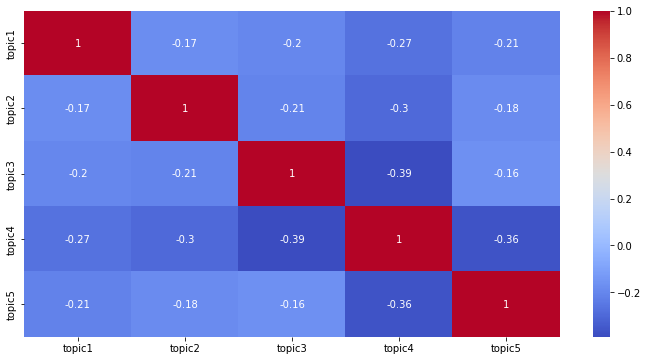

In [250]:
sns.heatmap(doc.corr(),annot=True,cmap='coolwarm')

In [251]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [252]:
bi_dash = pyLDAvis.sklearn.prepare(bi_lda, bigram_vectorized, bivectorizer, mds='tsne')
bi_dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      150.222153  -72.269554       1        1  29.126377
2       51.163364 -159.968018       2        1  18.451361
1      -73.144554   21.523815       3        1  17.570984
4      -66.410133 -110.606438       4        1  17.498153
0       54.417324   12.443444       5        1  17.353125, topic_info=                    Term        Freq       Total Category  logprob  loglift
878             year old  302.000000  302.000000  Default  30.0000  30.0000
394            last week  171.000000  171.000000  Default  29.0000  29.0000
396            last year  463.000000  463.000000  Default  28.0000  28.0000
102      chief executive  155.000000  155.000000  Default  27.0000  27.0000
375        interest rate   87.000000   87.000000  Default  26.0000  26.0000
276     general election  127.000000  127.000000  Default  25.0000  25.0000
366          human right   75.000000   75.000000  Default  24.0000  24.0000
478         mobile phone  176.000000  176.000000  Default  23.0000  23.0000
522            next week   71.000000   71.000000  Default  22.0000  22.0000
757       tell programme   64.000000   64.000000  Default  21.0000  21.0000
670          second half   56.000000   56.000000  Default  20.0000  20.0000
184    election campaign   69.000000   69.000000  Default  19.0000  19.0000
358       home secretary   51.000000   51.000000  Default  18.0000  18.0000
886         young people   51.000000   51.000000  Default  17.0000  17.0000
618       public service   50.000000   50.000000  Default  16.0000  16.0000
519      next generation   53.000000   53.000000  Default  15.0000  15.0000
304              go sale   49.000000   49.000000  Default  14.0000  14.0000
809       vice president   49.000000   49.000000  Default  13.0000  13.0000
53            anti virus   49.000000   49.000000  Default  12.0000  12.0000
181      economic growth   61.000000   61.000000  Default  11.0000  11.0000
206           file share   46.000000   46.000000  Default  10.0000  10.0000
345      high definition   72.000000   72.000000  Default   9.0000   9.0000
338           hard drive   49.000000   49.000000  Default   8.0000   8.0000
610       prime minister   50.000000   50.000000  Default   7.0000   7.0000
415         look forward   45.000000   45.000000  Default   6.0000   6.0000
668        search engine   42.000000   42.000000  Default   5.0000   5.0000
353           high speed   41.000000   41.000000  Default   4.0000   4.0000
232           first half   41.000000   41.000000  Default   3.0000   3.0000
404           let people   68.000000   68.000000  Default   2.0000   2.0000
191             end year   42.000000   42.000000  Default   1.0000   1.0000
680           semi final   39.359342   40.131727   Topic1  -4.9162   1.2141
317            good film   36.653365   37.415118   Topic1  -4.9874   1.2130
493            name good   36.221805   36.983598   Topic1  -4.9993   1.2127
878             year old  296.434936  302.891401   Topic1  -2.8971   1.2120
799              tv show   33.137479   33.907379   Topic1  -5.0882   1.2106
355              hip hop   31.987990   32.753762   Topic1  -5.1236   1.2099
88          camera phone   34.540684   35.375098   Topic1  -5.0468   1.2097
315        good director   31.122451   31.884876   Topic1  -5.1510   1.2093
312         good actress   31.059471   31.821232   Topic1  -5.1530   1.2093
788              top box   27.950581   28.725260   Topic1  -5.2585   1.2062
311           good actor   25.422781   26.184636   Topic1  -5.3533   1.2040
214           film maker   25.486823   26.252402   Topic1  -5.3508   1.2039
25          also include   26.242522   27.051869   Topic1  -5.3215   1.2032
683              set top   23.994075   24.766400   Topic1  -5.4111   1.2018
836             win good   23.182194   23.944697   Topic1  -5.4455   1.2012
275            game play   28.532516   29.491347   Topi

In  this work  we have taken  BBC news  dataset for analyzingthe   news   topics.   We   applied   various   machine   learning topicmodeling   approaches   (Latent   Dirichlet  Allocation   (LDA) unigram and bi-gram)   

From   the   comparative analysis made, it  has   been   observed   that   the topic   modeling approaches  find  the   hidden  topics  and relationship  betweenwords  and documents  with multiple  probability distributions.As a future work, using one of the topic modeling algorithms, we can implement various applications for  recommending research  articles, analyzing news articles   etc,  which can   be used for segregation of documents from top